### **SIR Model Parameters Estimation**

In [30]:
import numpy as np
import pandas as pd
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt
np.random.seed(1)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.optimize as optimize
from scipy.interpolate import UnivariateSpline

In [31]:
# est_R_0 = np.array([0.9] * 26)
# est_R_0 = np.random.normal(2, 0.5, size=(26,))
# est_R_0 = np.concatenate((np.random.normal(1, 0.5, size=(13,)), np.random.normal(2, 0.5, size=(13,))), axis=0)
# t_set = np.linspace(0, 765, 766)

def loss_func(est_param, I_true, t_length, type_loss_func, state, plot=False, return_series=False):
    t_set = np.linspace(0, t_length - 1, t_length)

    est_R_0 = est_param[:-1]
    gamma = abs(est_param[-1])

    N_dict = {
        "NJ": 9288994,
        "NY": 20201249,
        "CA": 39538223,
        "IL": 12812508,
        "PA": 13002700
    }

    N = N_dict[state]
    I0, R0 = 20, 0
    S0 = N - I0 - R0
    y0 = S0, I0, R0
    est_R_0 = np.abs(est_R_0)
    
    def random_beta(t):
        idx = int(t//30)
        idx = t_length//30 - 1 if idx >= t_length//30 else idx
        idx = 0 if idx < 0  else idx
        return est_R_0[idx] * gamma
    
    def deriv_dynamic(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = - beta(t) * S * I / N
        dIdt = beta(t) * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    
    ret = odeint(deriv_dynamic, y0, t_set, args=(N, random_beta, gamma))
    S, I, R = ret.T
    
    loss = type_loss_func(I_true, I / N)
    
    if plot:
        fig, ax = plt.subplots()
        ax.plot(range(len(I_true)), I_true, label='True')
        ax.plot(range(len(I_true)), I / N, label='Pred')
        plt.legend()
        plt.show()
    
    if return_series:
        return S, I, R
            
    return loss


## Implement on five states
#### New Jersey, New York, California, Illinois, Pennsylvania

In [32]:
# Import data 
N_NJ = 9288994
N_NY = 20201249
N_CA = 39538223
N_IL = 12812508
N_PA = 13002700

with open("NJ.txt") as f:
    string_NJ = f.readline()
NJ_data = np.array(string_NJ.split(",")).astype("float")/N_NJ

with open("NY.txt") as f:
    string_NY = f.readline()
NY_data = np.array(string_NJ.split(",")).astype("float")/N_NY

with open("CA.txt") as f:
    string_CA = f.readline()
CA_data = np.array(string_CA.split(",")).astype("float")/N_CA

with open("IL.txt") as f:
    string_IL = f.readline()
IL_data = np.array(string_IL.split(",")).astype("float")/N_IL

with open("PA.txt") as f:
    string_PA = f.readline()
PA_data = np.array(string_PA.split(",")).astype("float")/N_PA

In [33]:
time_period = [180, 320, 265]

#### **New Jersey**

In [34]:
# NJ Period 0
est_param0 = np.concatenate((np.random.normal(1, 1, size=(time_period[0]//30,)), np.random.normal(0.05, 0.05, size=(1,))))
optimzer_mae_nj0 = optimize.minimize(loss_func, 
                                     est_param0,
                                     args=(NJ_data[:time_period[0]], time_period[0], mean_absolute_error, "NJ"),
                                     method='Nelder-Mead', options={'maxiter':5000, 'disp':True})
optimzer_mse_nj0 = optimize.minimize(loss_func, 
                                     est_param0,
                                     args=(NJ_data[:time_period[0]], time_period[0], mean_squared_error, "NJ"),
                                     method='Nelder-Mead', options={'maxiter':5000, 'disp':True})

Optimization terminated successfully.
         Current function value: 0.000541
         Iterations: 596
         Function evaluations: 926
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 530
         Function evaluations: 832


In [72]:
est_param_mae_nj0 = np.abs(optimzer_mae_nj0.x)
est_r0_mae_nj0 = est_param_mae_nj0[:-1]
est_gamma = est_param_mae_nj0[-1]
S_nj0_mae, I_nj0_mae, R_nj0_mae = loss_func(est_param_mae_nj0, NJ_data[:time_period[0]], time_period[0], 
                             mean_absolute_error, 'NJ', False, True)

In [73]:
est_param_mse_nj0 = np.abs(optimzer_mse_nj0.x)
est_r0_mse_nj0 = est_param_mse_nj0[:-1]
est_gamma = est_param_mse_nj0[-1]
S_nj0_mse, I_nj0_mse, R_nj0_mse = loss_func(est_param_mse_nj0, NJ_data[:time_period[0]], time_period[0], 
                             mean_squared_error, 'NJ', False, True)

In [37]:
# NJ Period 1
est_param1 = np.concatenate((np.random.normal(1, 1, size=(time_period[1]//30,)), np.random.normal(0.05, 0.05, size=(1,))))
optimzer_mae_nj1 = optimize.minimize(loss_func, 
                                     est_param1,
                                     args=(NJ_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], mean_absolute_error, "NJ"), 
                                     method='Nelder-Mead',
                                     tol=1e-10,
                                     options={'maxiter':5000, 'disp':True})

optimzer_mse_nj1 = optimize.minimize(loss_func, 
                                     est_param1,
                                     args=(NJ_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], mean_squared_error, "NJ"), 
                                     method='Nelder-Mead',
                                     tol=1e-10,
                                     options={'maxiter':5000, 'disp':True})

Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 2074
         Function evaluations: 3152


In [74]:
est_param_mae_nj1 = np.abs(optimzer_mae_nj1.x)
est_r0_mae_nj1 = est_param_mae_nj1[:-1]
est_gamma = est_param_mae_nj1[-1]
S_nj1_mae, I_nj1_mae, R_nj1_mae = loss_func(est_param_mae_nj1, NJ_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], 
                             mean_absolute_error, 'NJ', False, True)

In [75]:
est_param_mse_nj1 = np.abs(optimzer_mse_nj1.x)
est_r0_mse_nj1 = est_param_mse_nj1[:-1]
est_gamma = est_param_mse_nj1[-1]
S_nj1_mse, I_nj1_mse, R_nj1_mse = loss_func(est_param_mse_nj1, NJ_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], 
                             mean_squared_error, 'NJ', False, True)

In [40]:
# NJ Period 2
est_param2 = np.concatenate((np.random.normal(1, 1, size=(time_period[2]//30,)), np.random.normal(0.05, 0.05, size=(1,))))
optimzer_mae_nj2 = optimize.minimize(loss_func, 
                                     est_param2,
                                     args=(NJ_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], mean_absolute_error, "NJ"), 
                                     method='Nelder-Mead',
                                     tol=1e-10,
                                     options={'maxiter':10000, 'disp':True})

optimzer_mse_nj2 = optimize.minimize(loss_func, 
                                     est_param2, 
                                     args=(NJ_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], mean_squared_error, "NJ"), 
                                     method='Nelder-Mead',
                                     tol=1e-10,
                                     options={'maxiter':10000, 'disp':True})

Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 770
         Function evaluations: 1325


In [76]:
est_param_mae_nj2 = np.abs(optimzer_mae_nj2.x)
est_r0_mae_nj2 = est_param_mae_nj2[:-1]
est_gamma = est_param_mae_nj2[-1]
S_nj2_mae, I_nj2_mae, R_nj2_mae = loss_func(est_param_mae_nj2, NJ_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], 
                             mean_absolute_error, 'NJ', False, True)

In [77]:
est_param_mse_nj2 = np.abs(optimzer_mse_nj2.x)
est_r0_mse_nj2 = est_param_mse_nj2[:-1]
est_gamma = est_param_mse_nj2[-1]
S_nj2_mse, I_nj2_mse, R_nj2_mse = loss_func(est_param_mse_nj2, NJ_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], 
                             mean_squared_error, 'NJ', False, True)

In [78]:
S_nj_mae = np.concatenate((S_nj0_mae, S_nj1_mae, S_nj2_mae))
I_nj_mae = np.concatenate((I_nj0_mae, I_nj1_mae, I_nj2_mae))
R_nj_mae = np.concatenate((R_nj0_mae, R_nj1_mae, R_nj2_mae))
est_r0_nj_mae = np.concatenate((est_r0_mae_nj0, est_r0_mae_nj1, est_r0_mae_nj2))

In [79]:
S_nj_mse = np.concatenate((S_nj0_mse, S_nj1_mse, S_nj2_mse))
I_nj_mse = np.concatenate((I_nj0_mse, I_nj1_mse, I_nj2_mse))
R_nj_mse = np.concatenate((R_nj0_mse, R_nj1_mse, R_nj2_mse))
est_r0_nj_mse = np.concatenate((est_r0_mse_nj0, est_r0_mse_nj1, est_r0_mse_nj2))

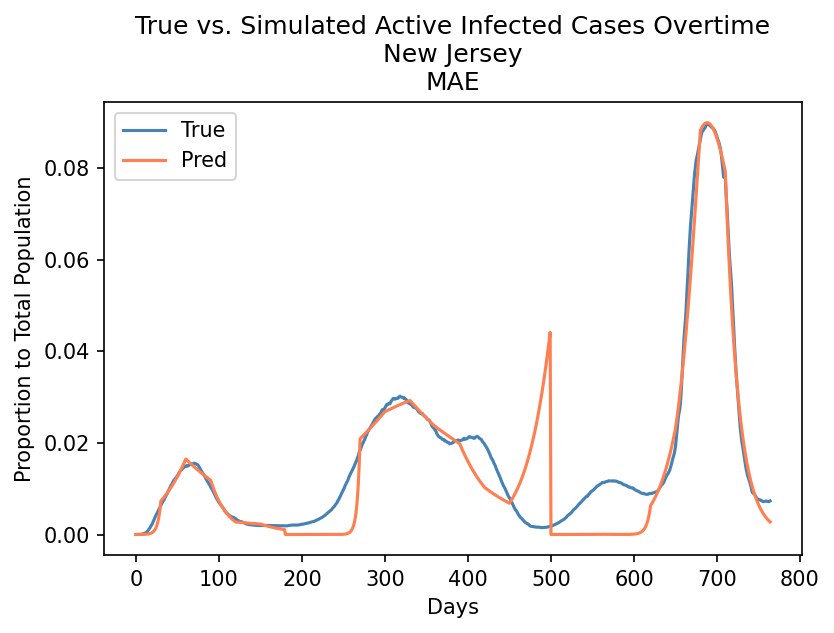

In [80]:
fig, ax = plt.subplots(dpi=150)
ax.plot(range(len(I_nj_mse)), NJ_data[:-1], label="True", color='steelblue', alpha=1)
ax.plot(range(len(I_nj_mae)), I_nj_mae / N_NJ, label="Pred", color='coral')
plt.xlabel("Days")
plt.ylabel("Proportion to Total Population")
plt.title("True vs. Simulated Active Infected Cases Overtime\nNew Jersey\nMAE")
plt.legend()
plt.show()

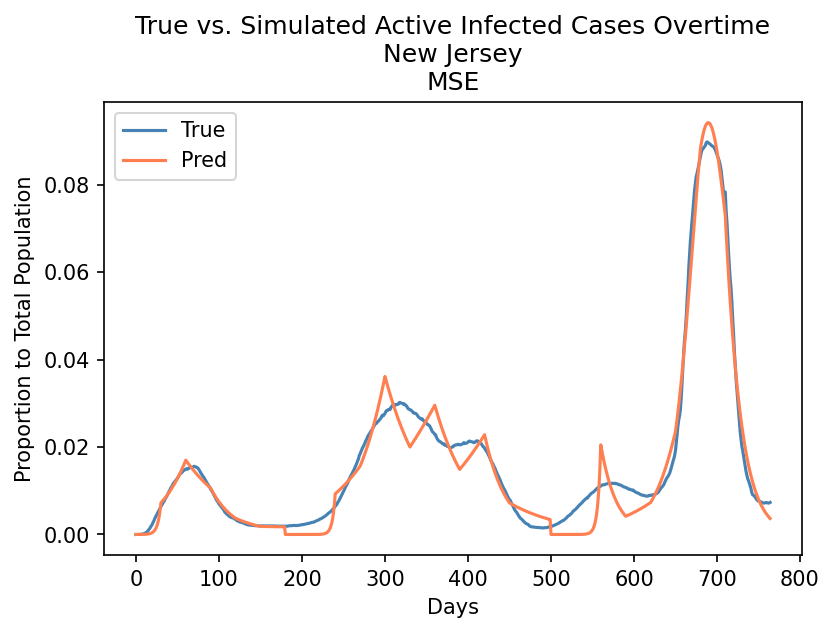

In [81]:
fig, ax = plt.subplots(dpi=150)
ax.plot(range(len(I_nj_mse)), NJ_data[:-1], label="True", color='steelblue', alpha=1)
ax.plot(range(len(I_nj_mse)), I_nj_mse / N_NJ, label="Pred", color='coral')
plt.xlabel("Days")
plt.ylabel("Proportion to Total Population")
plt.title("True vs. Simulated Active Infected Cases Overtime\nNew Jersey\nMSE")
plt.legend()
plt.show()

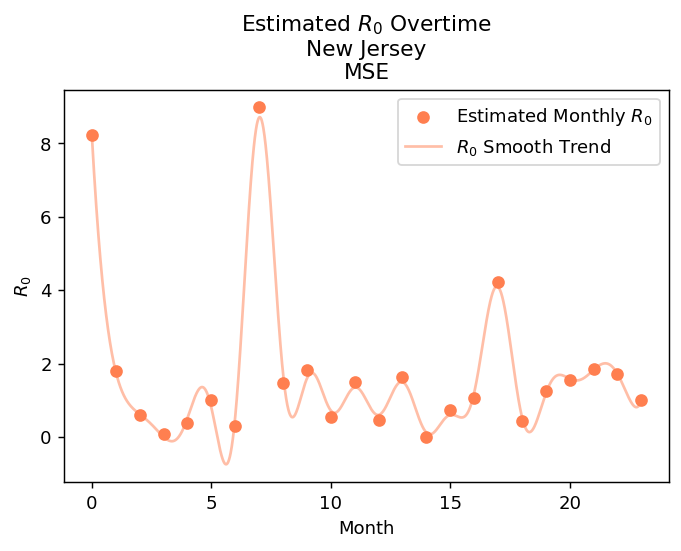

In [47]:
spl = UnivariateSpline(list(range(len(est_r0_nj_mse))), est_r0_nj_mse, k=5)
spl.set_smoothing_factor(0.5)
full_period = np.linspace(0, 23, 2000)
smoothed_est_r0 = spl(full_period)

fig, ax = plt.subplots(dpi=130)
ax.scatter(range(len(est_r0_nj_mse)), est_r0_nj_mse, color="coral", label="Estimated Monthly $R_0$")
ax.plot(full_period, smoothed_est_r0, color="coral", label="$R_0$ Smooth Trend", alpha=0.5)
plt.xlabel("Month")
plt.ylabel("$R_0$")
plt.title("Estimated $R_0$ Overtime\nNew Jersey\nMSE")
plt.legend()
plt.show()